In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)


class DataSet(torch.utils.data.Dataset):
    def __init__(self, train=True):
        dataset = datasets.MNIST(root='../data', train=train, download=True)
        self.data = dataset.data
        self.targ = dataset.targets

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targ[idx]


train_dataset = DataSet(train=True)

In [2]:
class GaussianTransform(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n
        self.log_std = nn.Parameter(torch.randn(n)).to(device)
        self.corr_lt = nn.Parameter(torch.randn(n, n)).to(device)
        self.mu = nn.Parameter(torch.randn(n)).to(device)

    def forward(self, x):
        mat = torch.tril(self.corr_lt, diagonal=0)
        mat = mat / mat.pow(2).sum(dim=1, keepdim=True).sqrt() 

        mat = mat * F.softplus(self.log_std).unsqueeze(-1) # suppose it cholesky lower triangular
        x = mat @ x.transpose(0, 1)
        x = x.transpose(0, 1)

        x += self.mu
        return x


class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 100),
            nn.Tanh()
        )

        self.trs = GaussianTransform(100)

        self.dec = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784)
        )

    def forward(self, x):
        z = self.enc(x)
        z = self.trs(z)
        z = z + (torch.sign(z) - z).detach()
        x = self.dec(z)
        return x

        




In [3]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
model = Model().to(device)
solver = optim.Adam(model.parameters(), lr=1e-4)

In [4]:
for ep in range(100):

    ep_loss = 0.
    for x, y in train_loader:
        x = x.flatten(1, -1).float().to(device) / 255.
        solver.zero_grad()

        pred = model(x)

        loss = F.mse_loss(pred, x) * 784
        loss.backward()
        solver.step()

        ep_loss += loss.item()
    
    if ep % 10 == 9:
        ep_loss /= len(train_loader)
        print(ep, ep_loss)



9 18.713736199263955
19 16.763314207437325
29 15.803255352928137
39 15.215581647614405
49 14.777891087811938
59 14.478305526578694
69 14.24545017454133
79 14.054052073011531
89 13.892331128441027
99 13.766452601014487


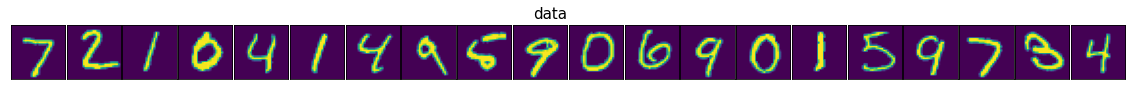

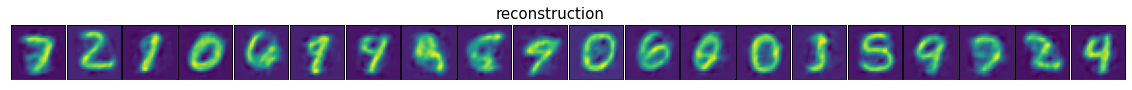

-


In [5]:
import matplotlib.pyplot as plt

test_dataset = DataSet(False)
num_image = 20

fig = plt.figure(figsize=(20, 2))
n = 0
for i in range(num_image):
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(test_dataset.data[n].cpu().reshape(28, 28).numpy())
    n += 1
fig.suptitle('data', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

fig = plt.figure(figsize=(20, 2))
n = 0
for i in range(num_image):

    x = test_dataset.data[n].reshape(1, 784).float().to(device)
    with torch.no_grad():
        x_pred = model(x)

    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(x_pred.cpu().data.numpy().reshape(28, 28))
    n += 1
fig.suptitle('reconstruction', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
print('-')